In [85]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time
import math
from numpy.linalg import norm


import skmob
from skmob.measures.individual import distance_straight_line, maximum_distance, number_of_visits, waiting_times, real_entropy


import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv
from torchsummary import summary


In [2]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 150, stride = 2, padding = 15, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 100, stride = 2, padding = 15, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 100, stride = 2, padding = 6, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 100, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out

In [3]:
g = torch.load("SV_200_steps_G.pt")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
nb = 4000
z = torch.randn((4000, 256, 1), device=device)
with torch.no_grad():
    generated = g(z)

traj_sim = generated.cpu().detach().numpy()

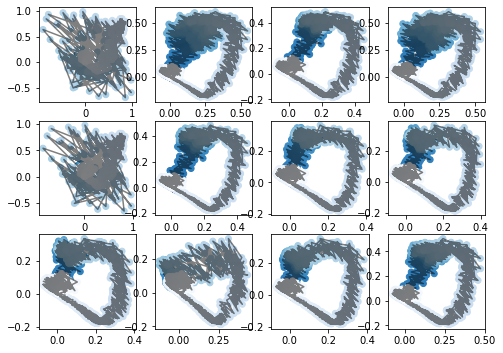

In [108]:
plt.figure(figsize = (8,8))
i = 4
padding=1500
for i in range(12):
    plt.subplot(4,4,i+1)
    plt.plot(generated[i,0,:], generated[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(generated[i,0,:], generated[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.savefig("GAN_Generated.png")
#     plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)


In [7]:
print(np.shape(generated))

torch.Size([4000, 2, 1500])


In [8]:
num_generate = 4000

In [10]:
print(np.shape(traj_sim))

(4000, 2, 1500)


In [18]:
dat_avg = pd.read_csv("../Random_Walk_Models/overview_minute.csv")

In [95]:
def get_speed(traj,t=1):
    f_np = np.asarray(traj)
    xs = np.subtract(f_np[0,:-1],f_np[0,1:])
    ys = np.subtract(f_np[1,:-1],f_np[1,1:])
    speed = np.divide(np.sqrt(np.add(np.power(xs, 2), np.power(ys, 2))),t)
    speed = np.insert(speed, 0,0)
    if(len(speed) != 1500):
        print("HERE!", np.shape(speed[0]))
    return speed

def get_acc(traj, t=1):
    f_np = np.asarray(traj)
    xs = np.subtract(f_np[0,:-1],f_np[0,1:])
    ys = np.subtract(f_np[1,:-1],f_np[1,1:])
    speed = np.divide(np.sqrt(np.add(np.power(xs, 2), np.power(ys, 2))),t)
    speed = np.insert(speed, 0,0)  
    acc = np.divide(np.subtract(speed[1:], speed[:-1]),t)
    acc = np.insert(acc, 0,0)
    return acc


def get_angle(traj):
    f_np = np.asarray(traj)
    angle = np.arctan2(np.subtract(f_np[1,:-1],f_np[1,1:]),np.subtract(f_np[0,:-1],f_np[0,1:]))
    angle = np.insert(angle, 0,0)
    deg = [math.degrees(x) for x in angle]
    return deg

def get_change_dir(a):
    a = np.asarray(a)
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0]=0
    return sum(signchange)

def triangle_area(arr, step_size = 1):
    if(step_size == 0):
        print("Cannot have step size be 0")
    tot_area = 0
    for i in range(len(arr)):
        [x1,y1,t] = arr[i]
        [x2,y2,t] = arr[i+step_size]
        try:
            [x3,y3,t] = arr[i+2*step_size]
        except:
            return tot_area
        Area = 1/2 *(x1*abs(y2 - y3) + x2*abs(y3 - y1) + x3*abs(y1 - y2))
        tot_area += Area
    return tot_area

In [42]:
gan_speed = []

for i in range(num_generate):
    rs_tmp = (get_speed(traj_sim[i,:,:],0.005))
    gan_speed.append(np.mean(rs_tmp))


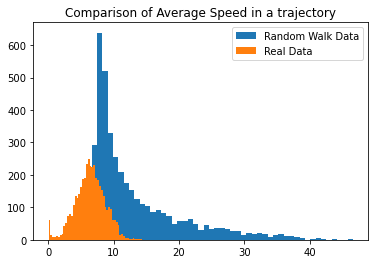

In [66]:
plt.hist(gan_speed, bins= 50, label="Random Walk Data")

plt.hist(dat_avg['average_speed'],bins = 50, label="Real Data")
plt.title("Comparison of Average Speed in a trajectory")
plt.legend()
plt.savefig("speed_gan.png")

In [40]:
gan_acc = []

for i in range(num_generate):
    rs_tmp = get_acc(traj_sim[i,:,:],0.005)
    gan_acc.append(np.mean(rs_tmp))
# rw_speed  = [item for sublist in s for item in sublist]


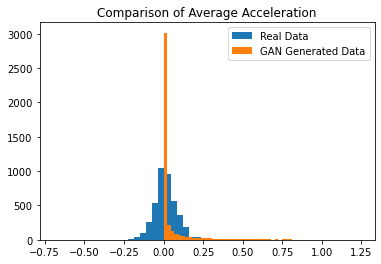

In [67]:

plt.hist(dat_avg['average_acceleration'],bins = 50, label="Real Data")
plt.hist(gan_acc, bins= 50, label="GAN Generated Data")
plt.title("Comparison of Average Acceleration")
plt.legend()
plt.savefig("acceleration_gan.png")

In [57]:
gan_ang = []

for i in range(num_generate):
    rs_tmp = get_angle(traj_sim[i,:,:])
    gan_ang.append(np.mean(rs_tmp))
# rw_speed  = [item for sublist in s for item in sublist]


In [62]:
print(min(gan_ang))
gan_ang[0:10]

27.021973204255268


[37.81555213230875,
 42.05454135437483,
 33.19447958254938,
 42.25164121989945,
 41.3769234995551,
 32.294459277869194,
 35.48361751677774,
 36.17436624916707,
 38.65211194670674,
 44.42227471869004]

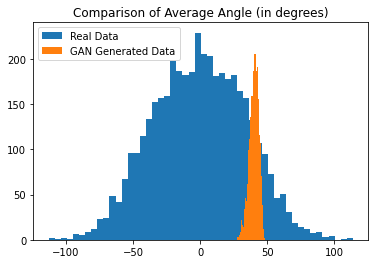

In [68]:

plt.hist(dat_avg['average_angle'],bins = 50, label="Real Data")
plt.hist(gan_ang, bins= 50, label="GAN Generated Data")
plt.title("Comparison of Average Angle (in degrees)")
plt.legend()
plt.savefig("angle_gan.png")

In [77]:
gan_ind = [i for i in range(num_generate) for j in range(1500)]
gan_ind = np.reshape(gan_ind, (len(gan_ind),1))
gan_t = [i/100 for i in range(num_generate*1500)]
gan_reshape = np.reshape(traj_sim, (1500*num_generate, 2))
print(np.shape(gan_reshape),np.shape(gan_t))
gan_t = np.reshape(gan_t, (len(gan_t),1))
all_data = np.append(gan_reshape, gan_t, 1)
all_data = np.append(all_data, gan_ind,1)
# all_data[:,2] = all_data[:,2]*100

gan_pd = pd.DataFrame(all_data, columns=["x",'y','t','user'])
# rw_pd = pd.Dataframe(all_data, latitude=1, longitude=2, datetime=3, user_id=4)

tdf = skmob.TrajDataFrame(gan_pd, latitude='x',longitude='y',datetime='t',user_id='user')



(6000000, 2) (6000000,)


In [80]:
dsl_df = distance_straight_line(tdf)

100%|██████████| 4000/4000 [00:33<00:00, 120.83it/s]


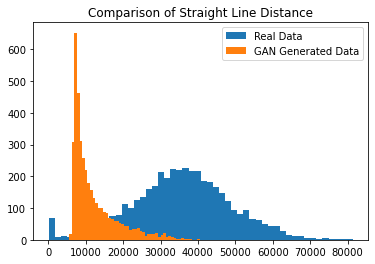

In [81]:
plt.hist(dat_avg['dist_traveled'],bins=50, label="Real Data")
plt.hist(dsl_df['distance_straight_line'],bins=50, label="GAN Generated Data")
plt.title("Comparison of Straight Line Distance")
plt.legend()
plt.savefig("line_dist_gan.png")

In [82]:
md_df = maximum_distance(tdf)

100%|██████████| 4000/4000 [00:34<00:00, 114.92it/s]


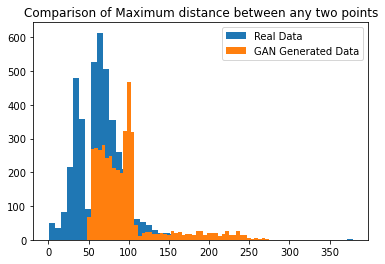

In [98]:
plt.hist(dat_avg['max_dist'],bins=50, label="Real Data")
plt.hist(md_df['maximum_distance'],bins=50, label="GAN Generated Data")
plt.title("Comparison of Maximum distance between any two points")
plt.legend()
plt.savefig("max_dist_gan.png")

In [86]:
d_sl = []
step_size = 50
for i in tqdm(range(num_generate)):
    d_tmp = 0
    for j in range(1,1499,step_size):
        p1 = gan_pd[gan_pd['user']==i].iloc[0][['x','y']]
        p2 = gan_pd[gan_pd['user']==i].iloc[1499][['x','y']]
        p3 = gan_pd[gan_pd['user']==i].iloc[j][['x','y']]
        d_tmp += norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
    d_sl.append(d_tmp)

 30%|███       | 1220/4000 [21:59<50:07,  1.08s/it] 


KeyboardInterrupt: 

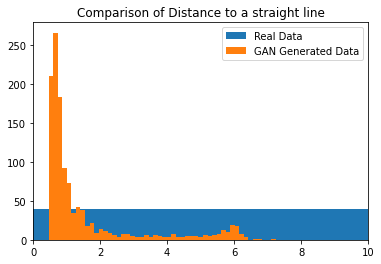

In [99]:
plt.hist(dat_avg['dist_to_line'][0:1220],bins=50, label="Real Data")
plt.hist(d_sl, bins=50, label="GAN Generated Data")
plt.title("Comparison of Distance to a straight line")
plt.xlim((0,10))
plt.legend()
plt.savefig("max_dist_gan.png")

In [96]:
dc = []
for i in tqdm(range(num_generate)):
    ang = get_angle(np.asarray(gan_pd[gan_pd['user']==i]))
    dc.append(get_change_dir(ang))

100%|██████████| 4000/4000 [00:48<00:00, 82.61it/s]


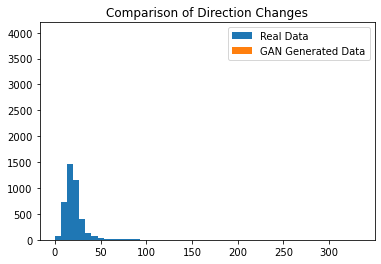

In [107]:
plt.hist(dat_avg['direction_changes'],bins=50, label="Real Data")
plt.hist(dc,bins=50, label="GAN Generated Data")
plt.title("Comparison of Direction Changes")
plt.legend()
plt.savefig("dir_changes_gan.png")

In [102]:
newa = gan_pd[['x','y','user']]
newa = np.asarray(newa)
max_dists = []
areas = []
for plotid in tqdm(range(num_generate)):
    c = newa[newa[:,2]==plotid]
    area = triangle_area(c,step_size=250)
    areas.append(abs(area))

100%|██████████| 4000/4000 [01:56<00:00, 34.32it/s]


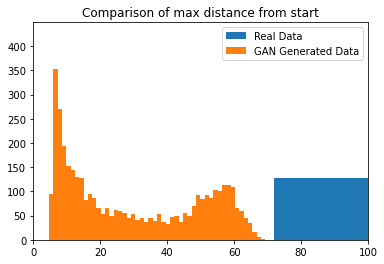

In [116]:
plt.hist(dat_avg['triangle_area'],bins=50, label="Real Data")
plt.hist(areas, bins=50, label="GAN Generated Data")
plt.title("Comparison of max distance from start")
plt.legend()
plt.xlim((0,100))
plt.savefig("max_from_start_gan.png")

In [106]:
newa = gan_pd[['x','y','user']]
newa = np.asarray(newa)
max_dists = []
for plotid in tqdm(range(num_generate)):
    c = newa[newa[:,2]==plotid]
#     print(np.shape(c))
#     dir_changes.append(c)

    xs = np.subtract(c[0,0],c[:,0])
    ys = np.subtract(c[0,1],c[:,1])
    dists = np.sqrt(np.add(np.power(xs, 2), np.power(ys, 2)))
    m = max(dists)
    
    max_dists.append(m)

100%|██████████| 4000/4000 [01:40<00:00, 39.67it/s]


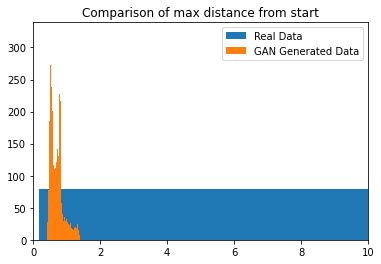

In [112]:
plt.hist(dat_avg['max_dist_start'],bins=50, label="Real Data")
plt.hist(max_dists, bins=50, label="GAN Generated Data")
plt.title("Comparison of max distance from start")
plt.legend()
plt.xlim((0,10))
plt.savefig("max_from_start_gan.png")